In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
import sklearn.linear_model


import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
mice = ['4139190.1','4139190.3','4139212.2','4139219.2','4139219.3','4139224.2','4139224.3','4139224.5']
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

In [4]:
mouse = '4139219.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]

sess = df_mouse.iloc[10]


In [5]:
VRDat,C,Cd, S, A = pp.load_scan_sess(sess)
#C = sp.stats.zscore(C,axis=0)
#cmax = np.max(C,axis=0)
#print(cmax.shape)
#C= np.divide(C,np.dot(np.ones([C.shape[0],1]),cmax[np.newaxis,:]))
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds)
C_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(C,VRDat.pos._values,tstart_inds,teleport_inds)


G:\My Drive\2P_Data\TwoTower\4139219.2\23_10_2018\TwoTower_Timeout\TwoTower_Timeout_002_011.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\preprocessing.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcas

G:\My Drive\2P_Data\TwoTower\4139219.2\23_10_2018\TwoTower_Timeout\TwoTower_Timeout_002_011.mat
#subsystem#not made into numpy array
Anot made into numpy array
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:250: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


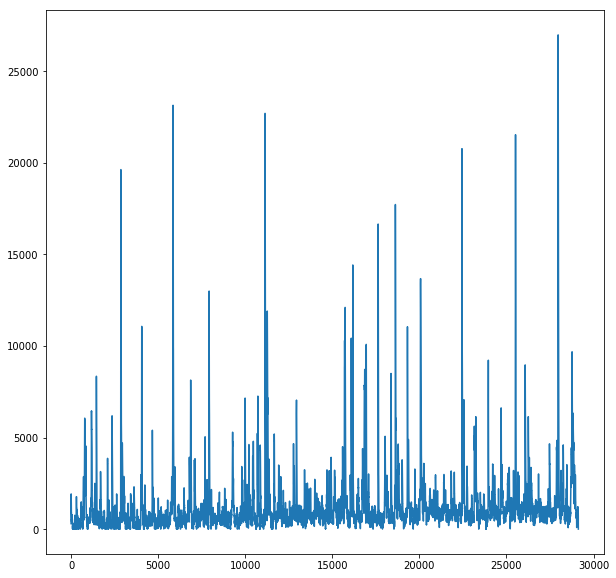

In [139]:
cell = 150
f,ax = plt.subplots(figsize = [10,10])
ax.plot(C[:,cell])

In [145]:
CC = C[VRDat.morph==1,:]
thr = int(.7*CC.shape[0])
mdl = sk.linear_model.ElasticNetCV()
mask = np.ones([CC.shape[1],])
mask[cell]=0
mask = mask>0
C_tr,C_tst = CC[:thr,mask ],CC[thr-1:-2,mask]
y_tr, y_tst = CC[1:thr,(1-mask)>0],CC[thr:,(1-mask)>0]

In [146]:
a=np.arange(3,10)
def trunc_toep(vec,k=10):
    T = sp.linalg.toeplitz(vec.ravel())
    trilm = np.tril_indices(T.shape[0])
    T[trilm]=0
    return T[:,-k:]

def conv_feats(X,K=5):
    XX = np.zeros([X.shape[0],K*X.shape[1]])
    print(XX.shape)
    for k in range(1,K+1):
        print(X[:-1,:].shape)
        XX[k:,X.shape[1]*(k-1):X.shape[1]*(k)] = X[:-k,:]
    return XX

tmp = C[:,:5]
XX = conv_feats(tmp)

(29126, 25)
(29125, 5)
(29125, 5)
(29125, 5)
(29125, 5)
(29125, 5)


In [147]:
XX_tr, XX_tst = conv_feats(C_tr), conv_feats(C_tst)

(5180, 3000)
(5179, 600)
(5179, 600)
(5179, 600)
(5179, 600)
(5179, 600)
(2220, 3000)
(2219, 600)
(2219, 600)
(2219, 600)
(2219, 600)
(2219, 600)


In [148]:
mdl.fit(XX_tr[1:,:],y_tr.ravel())
y_hat = mdl.predict(XX_tst)

C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


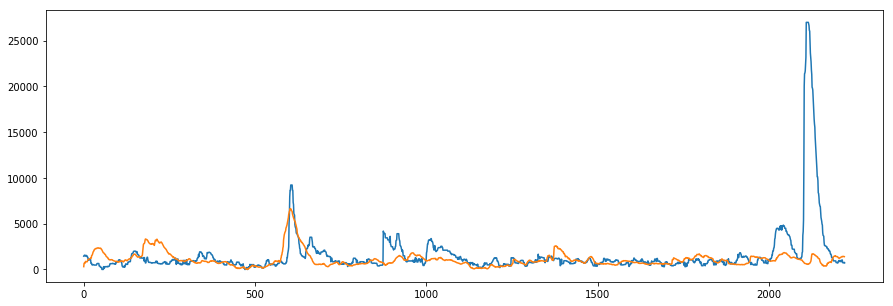

In [149]:
f,ax = plt.subplots(figsize=[15,5])
ax.plot(y_tst)
ax.plot(y_hat)